In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameter ----
Generations:    300
Iterations:     300
Total Iters:    90000
Signal power:   0.00 dB
Noise power:    20.00 dB
Noise uncert.:  5.00 dB
SNR:            -20.00 dB
Signal length:  0.001024 sec
Signal samples: 1024
Num. of bands:  4
Band to detect: 2
---- Simulation stats theory ----
Prob false alarm 0.1000
Prob detection   0.2605
Threshold        27670.7012
---- Running simulation ----
Noise act 17.161339820822956
Noise est 17.212480937945696
   infs left at  0.00%
Noise act 20.44267637388001
Noise est 20.434033956471186
 82.98s left at  0.33%
Noise act 24.37406385883004
Noise est 24.33691234790251
 85.34s left at  0.67%
Noise act 18.297325059634716
Noise est 18.31237741617015
 85.86s left at  1.00%
Noise act 24.6913640631805
Noise est 24.70412680117387
 89.05s left at  1.33%
Noise act 13.493882212515263
Noise est 13.477437211626734
 85.85s left at  1.67%
Noise act 19.902391542615646
Noise est 19.905689734187444
 83.81s left at  2.00%
Noise act 17.1737921905

Noise act 25.35099858341713
Noise est 25.30744339217011
 57.73s left at 32.33%
Noise act 20.258125190722378
Noise est 20.267827943064084
 57.42s left at 32.67%
Noise act 16.153695055414243
Noise est 16.108356926428897
 56.76s left at 33.00%
Noise act 16.87225820719324
Noise est 16.88962769289982
 56.60s left at 33.33%
Noise act 17.094446916707685
Noise est 17.169701340875765
 57.70s left at 33.67%
Noise act 19.13394787768524
Noise est 19.199263658230503
 55.71s left at 34.00%
Noise act 21.15581148198003
Noise est 21.15626762152059
 56.06s left at 34.33%
Noise act 16.535922061278725
Noise est 16.511469675803177
 55.12s left at 34.67%
Noise act 25.31732784497779
Noise est 25.362662325528213
 55.70s left at 35.00%
Noise act 15.476171904931768
Noise est 15.456874789236643
 54.56s left at 35.33%
Noise act 26.636041982528155
Noise est 26.611141782381818
 54.68s left at 35.67%
Noise act 18.52640958519671
Noise est 18.52157601455578
 56.32s left at 36.00%
Noise act 17.060255255783396
Noise est

Noise act 22.54266110000651
Noise est 22.482782543526746
 27.97s left at 66.67%
Noise act 22.559708964964184
Noise est 22.60499290972921
 27.79s left at 67.00%
Noise act 24.983356121078003
Noise est 25.02290091800605
 27.39s left at 67.33%
Noise act 18.284700108452256
Noise est 18.324515692901954
 26.97s left at 67.67%
Noise act 19.638787373528462
Noise est 19.626593062822728
 27.44s left at 68.00%
Noise act 28.466225710156323
Noise est 28.499130706533702
 26.47s left at 68.33%
Noise act 18.870156830237004
Noise est 18.913857695146962
 26.24s left at 68.67%
Noise act 22.63966611665252
Noise est 22.657513103714972
 26.33s left at 69.00%
Noise act 18.732772142742046
Noise est 18.724269936199313
 26.31s left at 69.33%
Noise act 20.92534808146254
Noise est 21.01924517972534
 25.54s left at 69.67%
Noise act 23.346225831418934
Noise est 23.356937911628812
 25.26s left at 70.00%
Noise act 19.00619029476332
Noise est 19.011244874492494
 25.11s left at 70.33%
Noise act 28.392351689600908
Noise 

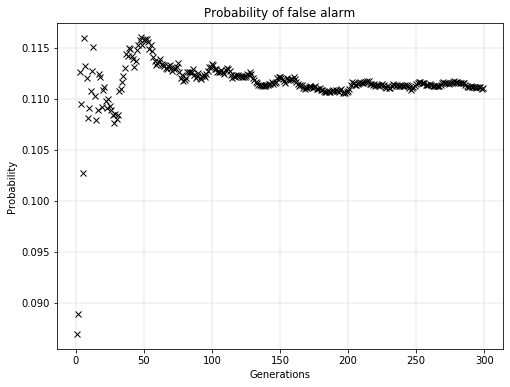

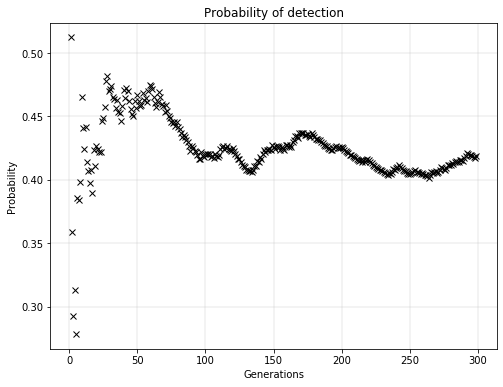

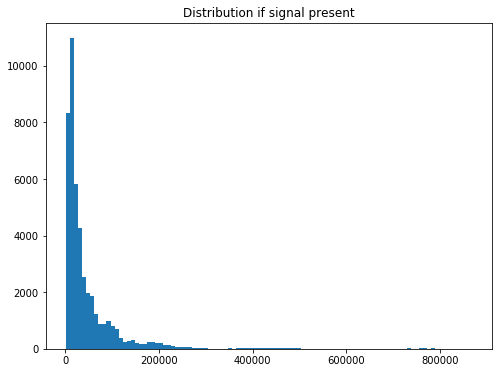

Sig Mean=47175.634, Standard Deviation=73696.467


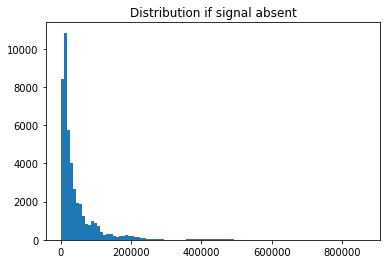

Noise Mean=46298.628, Standard Deviation=73959.922


In [33]:
def sim_wide(gens=100,
             itrs=100,
             f_sample=1e6,
             signal_strength=0.,
             noise_strength=0.,
             length_sec=None,
             num_samples=None,
             theo_pfa=0.1,
             threshold=None,
             noise_un=0.,
             bands=1,
             band_to_detect=0,
             nfft=1024):

    # Check and calculate length, in seconds and number of samples
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # Calculate threshold
    if threshold is None:
        threshold = ss.chi2_stats.get_thr(noise_power=noise_strength,
                                          pfa=theo_pfa,
                                          n=num_samples // bands,
                                          dB=True)

    print('---- Simulation parameter ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total Iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_strength))
    print('Noise power:    %.2f dB' % (noise_strength))
    print('Noise uncert.:  %.2f dB' % (noise_un))
    print('SNR:            %.2f dB' % (signal_strength - noise_strength))
    print('Signal length:  %.6f sec' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('Num. of bands:  %d' % (bands))
    print('Band to detect: %d' % (band_to_detect))

    theo_pd = ss.chi2_stats.get_pd(noise_strength,
                                   signal_strength,
                                   threshold,
                                   num_samples // bands,
                                   dB=True,
                                   bands=bands)

    print('---- Simulation stats theory ----')
    print('Prob false alarm %.4f' % (theo_pfa))
    print('Prob detection   %.4f' % (theo_pd))
    print('Threshold        %.4f' % (threshold))

    print('---- Running simulation ----')

    pfas = np.array([])  # Probability of false alarm list
    pds = np.array([])  # Probability of detection list
    en_sig = np.array([])  # Signal energy result list
    en_noise = np.array([])  # Noise energy result list
    current_time = None

    # Create new signal objects
    wm = ss.WirelessMicrophone(f_sample=f_sample, t_sec=length_sec)
    wgn = ss.WhiteGaussianNoise(f_sample=f_sample, t_sec=length_sec)

    # Outer generations loop
    for i in range(gens):

        # Calculate noise with uncertainty
        act_noise = np.random.normal(noise_strength, noise_un)
        
        # Array for noise estimation
        noise_est_list = np.array([])
        
        # Run itertations and store results in result array
        result = np.array([])
        for j in range(itrs):
            
            if np.size(noise_est_list) == 0:
                smooth_noise_est = act_noise
            else:    
                smooth_noise_est = np.mean(noise_est_list)
#                 smooth_noise_est = noise_est_list[0]
            
            threshold = ss.chi2_stats.get_thr(noise_power=smooth_noise_est,
                                          pfa=theo_pfa,
                                          n=num_samples // bands,
                                          dB=True)
            
            result_tmp, en, noise_est = iteration(wm, wgn, signal_strength,
                                                  act_noise, threshold,
                                                  f_sample, nfft, bands,
                                                  band_to_detect, theo_pfa,
                                                  num_samples)
            
            result = np.append(result, result_tmp)
            if result_tmp == 1 or result_tmp == 2:
                en_sig = np.append(en_sig, en)
            else:
                en_noise = np.append(en_noise, en)
                
            if np.size(noise_est_list) == 50:
                noise_est_list = np.delete(noise_est_list, 0)
            noise_est_list = np.append(noise_est_list, noise_est)
        
        print('Noise act', act_noise)
        print('Noise est', np.mean(noise_est_list))

        # Convert to numpy array
        result = np.asarray(result)

        # Calculate statistics and store in arrays
        pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) +
                                         np.sum(result == 4))
        pd_tmp = np.sum(result == 1) / (np.sum(result == 1) +
                                        np.sum(result == 2))
        pfas = np.append(pfas, pfa_tmp)
        pds = np.append(pds, pd_tmp)

        # Print simulation progress
        rem, percent, current_time = ss.util_sim.runtime_stats(
            current_time, gens, i)
        print('%6.2fs left at %5.2f%%' % (rem, percent))

    # Compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    print('---- Simulation stats ----')
    print('Prob false alarm theory %.4f' % (theo_pfa))
    print('Prob false alarm sim    %.4f' % (pfa))
    print('Prob detection theory   %.4f' % (theo_pd))
    print('Prob detection sim      %.4f' % (pd))

    ss.util_sim.print_convergence(gens, pfas, pds)
    ss.util_sim.print_distibution(en_sig, en_noise)
    return pfa, pd


def iteration(wm,
              wgn,
              signal_strength,
              noise_strength,
              threshold,
              f_sample=1.e6,
              nfft=1024,
              bands=1,
              band_to_detect=0,
              theo_pfa=0.,
              num_samples=1024):

    # Generate signal, center frequency does not matter with single band ED
    sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

    # Generate noise
    noise = wgn.get_signal(power=noise_strength, dB=True)

    # Randomly decide whether signal should be present
    sig_present = bool(np.random.randint(2))
    if sig_present:
        both = sig + noise
    else:
        both = noise

    # Classic (single band) energy detector
    # eng = ss.EnergyDetector.get(both)

    # Mutliband stft based energy detector
    sft = ss.Stft(n=nfft, window='box')
    f, psd = sft.stft(sig=both, f_sample=f_sample, normalized=False, dB=False)
    edf = ss.FreqEnergyDetector(num_bands=bands,
                                f_sample=1e6,
                                fft_len=nfft,
                                freqs=f)
    eng = edf.detect(psd)[band_to_detect]

    # Estimate noise from band with only noise
    noise_pow = np.sum(psd[0:nfft // bands])
    noise_pow /= (nfft // bands)
    noise_pow = 10. * np.log10(noise_pow)
    #     print(noise_pow)
    
#     threshold = ss.chi2_stats.get_thr(noise_power=noise_strength,
#                                       pfa=0.1,
#                                       n=num_samples // bands,
#                                       dB=True)
    #     print(threshold)

    # Threshold
    sig_detected = eng > threshold

    # Log signal and detection outcome
    if sig_present and sig_detected:
        return 1, eng, noise_pow
    elif sig_present and not sig_detected:
        return 2, eng, noise_pow
    elif not sig_present and sig_detected:
        return 3, eng, noise_pow
    else:
        return 4, eng, noise_pow


# Wide band energy detector simulation
length = 1024
_ = sim_wide(
    gens=300,
    itrs=300,
    f_sample=1e6,  # in Hz
    signal_strength=0.0,  # in dB
    noise_strength=20.0,  # in dB
    num_samples=length,  # in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_un=5.0,  # standard deviation of the noise normal distribution
    bands=4,  # number of bands
    band_to_detect=2,  # which band to detect in
    nfft=length)  # length of fft